In [1]:
# import argparse
# import os
# import warnings
# import sys
# warnings.filterwarnings('ignore')
# from numbers import Number

# # sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__)))))


# import mmcv
# import numpy as np
# import torch
# from mmcv import DictAction
# from mmcv.runner import (get_dist_info, init_dist, load_checkpoint,
#                          wrap_fp16_model)

# from model.apis import multi_gpu_test, single_gpu_test
# from model.datasets import build_dataloader, build_dataset
# from model.models import build_classifier
# from model.utils import (auto_select_device, get_root_logger,
#                          setup_multi_processes, wrap_distributed_model,
#                          wrap_non_distributed_model)



# # from utils import calculate_metric

# class Paser_args():
#     def __init__(self):
#         self.config = "configs/NIH_ChestX-ray14_CTransCNN.py"
#         self.checkpoint = "save/epoch_20.pth"
#         self.out = "out/out.pkl"
#         self.out_items = ['all']
#         self.metrics = ["multi_auc"]
#         self.show = None
#         self.show_dir = None
#         self.gpu_collect = None
#         self.tmpdir = None
#         self.cfg_options = None
#         self.metric_options = None
#         self.show_options = None
#         self.gpu_ids = None
#         self.gpu_id = 0
#         self.launcher = 'none'
#         self.local_rank = 0
#         self.device = 'cuda'
#         if 'LOCAL_RANK' not in os.environ:
#             os.environ['LOCAL_RANK'] = str(self.local_rank)


# # def main():
#     # args = parse_args()
# args = Paser_args()

# cfg = mmcv.Config.fromfile(args.config)
# if args.cfg_options is not None:
#     cfg.merge_from_dict(args.cfg_options)

# # set multi-process settings
# setup_multi_processes(cfg)

# # set cudnn_benchmark
# if cfg.get('cudnn_benchmark', False):
#     torch.backends.cudnn.benchmark = True
# cfg.model.pretrained = None

# if args.gpu_ids is not None:
#     cfg.gpu_ids = args.gpu_ids[0:1]
#     warnings.warn('`--gpu-ids` is deprecated, please use `--gpu-id`. '
#                     'Because we only support single GPU mode in '
#                     'non-distributed testing. Use the first GPU '
#                     'in `gpu_ids` now.')
# else:
#     cfg.gpu_ids = [args.gpu_id]
# cfg.device = args.device or auto_select_device()

# # init distributed env first, since logger depends on the dist info.
# if args.launcher == 'none':
#     distributed = False
# else:
#     distributed = True
#     init_dist(args.launcher, **cfg.dist_params)

# dataset = build_dataset(cfg.data.test, default_args=dict(test_mode=True))

# # build the dataloader
# # The default loader config
# loader_cfg = dict(
#     # cfg.gpus will be ignored if distributed
#     num_gpus=1 if cfg.device == 'ipu' else len(cfg.gpu_ids),
#     dist=distributed,
#     round_up=True,
# )
# # The overall dataloader settings
# loader_cfg.update({
#     k: v
#     for k, v in cfg.data.items() if k not in [
#         'train', 'val', 'test', 'train_dataloader', 'val_dataloader',
#         'test_dataloader'
#     ]
# })
# test_loader_cfg = {
#     **loader_cfg,
#     'shuffle': False,  # Not shuffle by default
#     'sampler_cfg': None,  # Not use sampler by default
#     **cfg.data.get('test_dataloader', {}),
# }
# # the extra round_up data will be removed during gpu/cpu collect
# data_loader = build_dataloader(dataset, **test_loader_cfg)

# # build the model and load checkpoint
# model = build_classifier(cfg.model)
# fp16_cfg = cfg.get('fp16', None)
# if fp16_cfg is not None:
#     wrap_fp16_model(model)
# checkpoint = load_checkpoint(model, args.checkpoint, map_location='cpu')

# if 'CLASSES' in checkpoint.get('meta', {}):
#     CLASSES = checkpoint['meta']['CLASSES']
# else:
#     from model.datasets import ImageNet
#     warnings.simplefilter('once')
#     warnings.warn('Class names are not saved in the checkpoint\'s '
#                     'meta data, use imagenet by default.')
#     CLASSES = ImageNet.CLASSES

# if not distributed:
#     model = wrap_non_distributed_model(
#         model, device=cfg.device, device_ids=cfg.gpu_ids)
#     if cfg.device == 'ipu':
#         from mmcv.device.ipu import cfg2options, ipu_model_wrapper
#         opts = cfg2options(cfg.runner.get('options_cfg', {}))
#         if fp16_cfg is not None:
#             model.half()
#         model = ipu_model_wrapper(model, opts, fp16_cfg=fp16_cfg)
#         data_loader.init(opts['inference'])
#     model.CLASSES = CLASSES
#     show_kwargs = args.show_options or {}
#     outputs = single_gpu_test(model, data_loader, args.show, args.show_dir,
#                                 **show_kwargs)
# else:
#     model = wrap_distributed_model(
#         model,
#         device=cfg.device,
#         device_ids=[int(os.environ['LOCAL_RANK'])],
#         broadcast_buffers=False)
#     outputs = multi_gpu_test(model, data_loader, args.tmpdir,
#                                 args.gpu_collect)

# rank, _ = get_dist_info()
# if rank == 0:
#     results = {}
#     logger = get_root_logger()
#     if args.metrics:
#         eval_results = dataset.evaluate(
#             results=outputs,
#             metric=args.metrics,
#             metric_options=args.metric_options,
#             logger=logger)
#         results.update(eval_results)
#         for k, v in eval_results.items():
#             if isinstance(v, np.ndarray):
#                 v = [round(out, 2) for out in v.tolist()]
#             elif isinstance(v, Number):
#                 v = round(v, 2)
#             else:
#                 raise ValueError(f'Unsupport metric type: {type(v)}')
#             print(f'\n{k} : {v}')
#     if args.out:
#         if 'none' not in args.out_items:
#             scores = np.vstack(outputs)
#             pred_score = np.max(scores, axis=1)
#             pred_label = np.argmax(scores, axis=1)
#             pred_class = [CLASSES[lb] for lb in pred_label]
#             res_items = {
#                 'class_scores': scores,
#                 'pred_score': pred_score,
#                 'pred_label': pred_label,
#                 'pred_class': pred_class
#             }
#             if 'all' in args.out_items:
#                 results.update(res_items)
#             else:
#                 for key in args.out_items:
#                     results[key] = res_items[key]
#         print(f'\ndumping results to {args.out}')
#         mmcv.dump(results, args.out)

In [2]:
import pickle

# res_items = pickle.load("out/out.pkl")
with open("out/out.pkl", 'rb') as file:
    res_items = pickle.load(file)
outputs = res_items["class_scores"]

In [3]:
import torch
import numpy as np
from tqdm import tqdm
from glob import glob
import os
import pandas as pd
import random


os.environ["CUDA_VISIBLE_DEVICES"] = "1"

SEED = 85
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

labels_train_val = pd.read_csv('../../../data/train_val_list.txt')
labels_train_val.columns = ['Image_Index']
labels_test = pd.read_csv('../../../data/test_list.txt')
labels_test.columns = ['Image_Index']

disease_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'No Finding']
# NIH Dataset Labels CSV File 
labels_df = pd.read_csv('../../../data/Data_Entry_2017.csv')
labels_df.columns = ['Image_Index', 'Finding_Labels', 'Follow_Up_#', 'Patient_ID',
                  'Patient_Age', 'Patient_Gender', 'View_Position',
                  'Original_Image_Width', 'Original_Image_Height',
                  'Original_Image_Pixel_Spacing_X',
                  'Original_Image_Pixel_Spacing_Y', 'dfd']
# One hot encoding
for diseases in tqdm(disease_labels): 
    labels_df[diseases] = labels_df['Finding_Labels'].map(lambda result: 1 if diseases in result else 0)

labels_df['Finding_Labels'] = labels_df['Finding_Labels'].apply(lambda s: [l for l in str(s).split('|')])

num_glob = glob('../../../data/images_all/*.png')
img_path = {os.path.basename(x): x for x in num_glob}

labels_df['Paths'] = labels_df['Image_Index'].map(img_path.get)
unique_patients = np.unique(labels_df['Patient_ID'])

train_val_df = labels_df[labels_df['Image_Index'].isin(labels_train_val['Image_Index'])]
test_df = labels_df[labels_df['Image_Index'].isin(labels_test['Image_Index'])]
test_df.reset_index(drop=True, inplace=True)

print('train_val size', train_val_df.shape[0])
print('test size', test_df.shape[0])

/userHome/userhome4/seungyeon/miniconda3/envs/ctrans/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 15/15 [00:00<00:00, 28.11it/s]


train_val size 86523
test size 25595


In [4]:
import pickle

# Pickle 파일에서 numpy 배열 불러오기
with open('./pkl_data/all_labels.pkl', 'rb') as file:
    all_labels = pickle.load(file)
    
outputs = torch.Tensor(outputs)

In [5]:
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from utils import calculate_metric as cm

import pandas as pd

metrics = ['hamming_loss', 'ranking_loss', 'multilabel_coverage', 'one_error', 'subset_accuracy', 'macro_f1_score', 'micro_f1_score']
df = test_df.loc[:, ['Image_Index', 'Finding_Labels', 'Paths']]

res_df = cm.accuracy_each_class(predicts=outputs, targets=all_labels)

res_df = cm.accurcay_overall(predicts=outputs, targets=all_labels)


Accuracy for each class:
Atelectasis - Accuracy: 0.8699
Consolidation - Accuracy: 0.9291
Infiltration - Accuracy: 0.7251
Pneumothorax - Accuracy: 0.8959
Edema - Accuracy: 0.9630
Emphysema - Accuracy: 0.9573
Fibrosis - Accuracy: 0.9830
Effusion - Accuracy: 0.7855
Pneumonia - Accuracy: 0.9783
Pleural_Thickening - Accuracy: 0.9553
Cardiomegaly - Accuracy: 0.9584
Nodule - Accuracy: 0.9365
Mass - Accuracy: 0.9301
Hernia - Accuracy: 0.9967
No Finding - Accuracy: 0.6140
Overall Accuracy: 0.8985
Overall Accuracy before reshape: 0.3092


In [6]:
import numpy as np
from sklearn.metrics import f1_score

# Assuming 'all_labels' and 'all_outputs' are already defined and have compatible shapes

# Convert ensemble probabilities to class predictions using a threshold (e.g., 0.5)
threshold = 0.5
each_class_f1_preds = (outputs > threshold).to(int)

# Calculate accuracy for each class
print("f1 for each class:")
for i, disease in enumerate(disease_labels):
    accuracy_class = f1_score(all_labels[:, i].cpu(), each_class_f1_preds[:, i])
    print(f'{disease} - f1: {accuracy_class:.4f}')

# Calculate overall accuracy
overall_accuracy = f1_score(all_labels.cpu().reshape(-1), each_class_f1_preds.reshape(-1))
print(f'Overall f1: {overall_accuracy:.4f}')


f1 for each class:
Atelectasis - f1: 0.1043
Consolidation - f1: 0.0000
Infiltration - f1: 0.3967
Pneumothorax - f1: 0.0000
Edema - f1: 0.0166
Emphysema - f1: 0.0000
Fibrosis - f1: 0.0000
Effusion - f1: 0.4617
Pneumonia - f1: 0.0000
Pleural_Thickening - f1: 0.0000
Cardiomegaly - f1: 0.0239
Nodule - f1: 0.0133
Mass - f1: 0.0346
Hernia - f1: 0.0000
No Finding - f1: 0.5894
Overall f1: 0.3815


In [7]:

res_df = cm.Hamming_loss(predicts=outputs, targets=all_labels)

res_df = cm.Ranking_loss(predicts=outputs, targets=all_labels)

res_df = cm.Multilabel_Accuracy(predicts=outputs, targets=all_labels)

res_df = cm.Multilabel_Coverage(predicts=outputs, targets=all_labels)

res_df = cm.one_error(predicts=outputs, targets=all_labels)

res_df = cm.Subset_Accuracy(predicts=outputs, targets=all_labels)

res_df = cm.Macro_F1_Score(predicts=outputs, targets=all_labels)

res_df = cm.Micro_F1_Score(predicts=outputs, targets=all_labels)

Hamming Loss: 0.1015


Ranking Loss: 0.1613
Multilabel Accuracy: 0.3694
Multilabel Coverage: 4.1114
One Error: 0.5466
Subset Accuracy: 0.3092
Macro F1 Score: 0.1094
Micro F1 Score: 0.3815


In [8]:
if not os.path.exists('results'):
    os.makedirs('results')

metrics = ['hamming_loss', 'ranking_loss', 'multilabel_coverage', 'one_error', 'subset_accuracy', 'macro_f1_score', 'micro_f1_score']
excel_writer = pd.ExcelWriter('results/scores_ctrans.xlsx', engine='xlsxwriter')

df = test_df.loc[:, ['Image_Index', 'Finding_Labels', 'Paths']]

for metric in metrics:
    res_df = cm.results_low_score_image(df, predicts=outputs, targets=all_labels, metric=metric)
    print(metric.replace('_', ' '))
    res_df.to_excel(excel_writer, sheet_name=metric.replace('_', ' '), index=False)

excel_writer.close()
print('Results saved to results/scores_ctrans.xlsx')

hamming loss


/userHome/userhome4/seungyeon/miniconda3/envs/ctrans/lib/python3.9/site-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)


ranking loss


/userHome/userhome4/seungyeon/miniconda3/envs/ctrans/lib/python3.9/site-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)


multilabel coverage
one error
subset accuracy
macro f1 score
micro f1 score
Results saved to results/scores_ctrans.xlsx


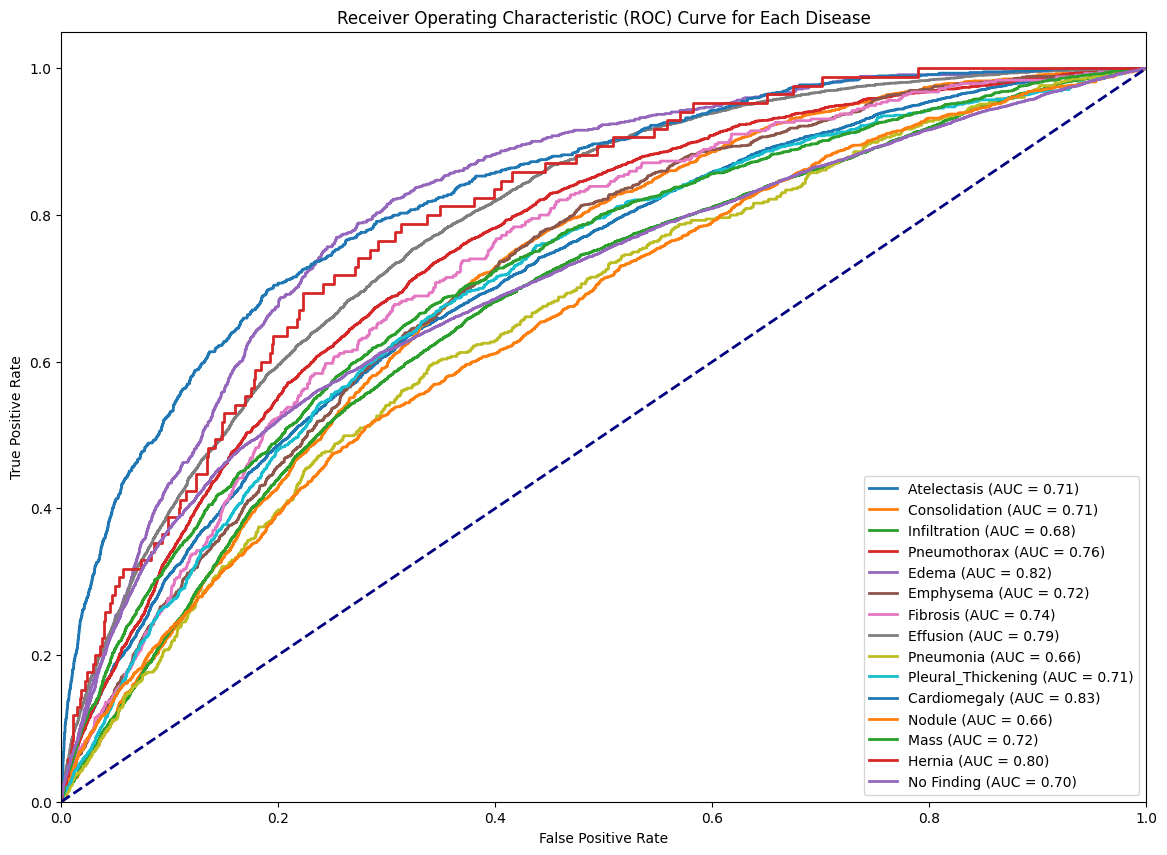

Atelectasis - ROC AUC Score: 0.7140
Consolidation - ROC AUC Score: 0.7119
Infiltration - ROC AUC Score: 0.6774
Pneumothorax - ROC AUC Score: 0.7561
Edema - ROC AUC Score: 0.8185
Emphysema - ROC AUC Score: 0.7199
Fibrosis - ROC AUC Score: 0.7376
Effusion - ROC AUC Score: 0.7876
Pneumonia - ROC AUC Score: 0.6594
Pleural_Thickening - ROC AUC Score: 0.7073
Cardiomegaly - ROC AUC Score: 0.8314
Nodule - ROC AUC Score: 0.6569
Mass - ROC AUC Score: 0.7203
Hernia - ROC AUC Score: 0.8000
No Finding - ROC AUC Score: 0.7049
Overall Accuracy: 0.8304


In [9]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


# Plot ROC curve for each class
plt.figure(figsize=(14, 10))
for i, disease in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(all_labels[:, i].cpu(), outputs[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'{disease} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Disease')
plt.legend(loc='lower right')
plt.savefig("ROC Curve for Each Disease")
plt.show()

# Print ROC AUC scores for each class
for i, disease in enumerate(disease_labels):
    roc_auc_label = roc_auc_score(all_labels[:, i].cpu(), outputs[:, i], average="macro")
    print(f'{disease} - ROC AUC Score: {roc_auc_label:.4f}')
    
# Calculate overall accuracy
overall_accuracy = roc_auc_score(all_labels.cpu().reshape(-1), outputs.reshape(-1), average="micro")
print(f'Overall Accuracy: {overall_accuracy:.4f}')    
